In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

plt.style.use('ggplot')

In [3]:
covid_states_url = 'https://covidtracking.com/api/states/daily.csv'

In [5]:
covid_data = pd.read_csv(covid_states_url)

print(*list(covid_data.columns), sep=", ")
covid_data #.head(10)

date, state, positive, negative, pending, hospitalizedCurrently, hospitalizedCumulative, inIcuCurrently, inIcuCumulative, onVentilatorCurrently, onVentilatorCumulative, recovered, hash, dateChecked, death, hospitalized, total, totalTestResults, posNeg, fips, deathIncrease, hospitalizedIncrease, negativeIncrease, positiveIncrease, totalTestResultsIncrease


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200405,AK,185.0,6099.0,NaN,NaN,20.0,NaN,NaN,NaN,...,20.0,6284,6284,6284,2,1.0,4.0,230.0,14.0,244.0
1,20200405,AL,1796.0,11282.0,NaN,NaN,231.0,NaN,NaN,NaN,...,231.0,13078,13078,13078,1,2.0,19.0,2009.0,216.0,2225.0
2,20200405,AR,830.0,10412.0,NaN,67.0,130.0,NaN,43.0,27.0,...,130.0,11242,11242,11242,5,2.0,130.0,785.0,87.0,872.0
3,20200405,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200405,AZ,2269.0,25141.0,NaN,NaN,310.0,NaN,108.0,NaN,...,310.0,27410,27410,27410,4,12.0,13.0,0.0,250.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,50,32,32,41,NaN,NaN,NaN,NaN,NaN
1705,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5,5,5,45,NaN,NaN,NaN,NaN,NaN
1706,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,48,NaN,NaN,NaN,NaN,NaN
1707,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,39,39,39,53,NaN,NaN,NaN,NaN,NaN


# plotting functions

In [6]:
figsiz0 = np.array(mpl.rcParams["figure.figsize"])

#date_format = '%m/%d'
date_format = '%b %d'

In [28]:
def plot_fit(ax, lag, dates, ydata, color="r", **kwargs):
    x = mpl.dates.datestr2num(dates)[:lag]
    y = ydata.to_numpy()[:lag]
    fit = np.polyfit(x, np.log10(y), 1)
    ax.plot_date(x, 10**np.poly1d(fit)(x),"-", color=color, **kwargs)

    dbl_time = np.log10(2)/fit[0]
    growth = 10**fit[0] - 1
    ax.text(.6, .2, f"doubling = {dbl_time:.1f} days", transform=ax.transAxes, color=color)
    ax.text(.6, .1, f"daily growth = {growth:.0%}", transform=ax.transAxes, color=color)

    return fit

def plot_state_data(state, stdata, rowcols, PLOT_TOTAL=False, fit_lag_death=None, fit_lag_pos=None):
    dates = stdata.date.to_numpy(dtype=str)
    cmap = plt.get_cmap("tab10")
    tab10 = [cmap(i) for i in range(10)]
    
    figsiz = figsiz0*np.array(rowcols[::-1])*.9
    fig, axs = plt.subplots(*rowcols, figsize=figsiz)
    title = "Entire US" if len(state)>2 else 'State: '+state
    fig.suptitle(title, y=0.93, fontsize='xx-large')

    ax = axs[0][0]
    ax.plot_date(mpl.dates.datestr2num(dates), stdata.positive)
    if PLOT_TOTAL:
        ax.plot_date(mpl.dates.datestr2num(dates), (stdata.positive+stdata.negative))
    # rule = mpl.dates.rrulewrapper(YEARLY, byeaster=1, interval=5)
    # loc = mpl.dates.RRuleLocator(rule)
    # ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.set_ylabel('positives')

    ax = axs[1][0]
    ax.plot_date(mpl.dates.datestr2num(dates), stdata.positive, label='positive')
    ax.plot_date(mpl.dates.datestr2num(dates), (stdata.positive+stdata.negative), label='tested')
    if fit_lag_pos:
        plot_fit(ax, fit_lag_pos, dates, stdata.positive, color="r")
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.set_ylabel('positives')
    ax.set_yscale('log')
    ax.legend()

    ax = axs[0][1]
    color = tab10[2]
    ydata = 100*stdata.positive/(stdata.positive+stdata.negative)
    ax.plot_date(mpl.dates.datestr2num(dates), ydata, color=color)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.set_ylim([0,max(50, ydata.max()*1.05)])
    ax.set_ylabel('positives as % of tested')

    ax = axs[1][1]
    color = "black"
    ax.plot_date(mpl.dates.datestr2num(dates), stdata.death, color=color)
    if fit_lag_death:
        plot_fit(ax, fit_lag_death, dates, stdata.death, color=color)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.set_ylabel('deaths')
    ax.set_yscale('log')

    if rowcols[1]==3:
        ax = axs[0][2]
        color = tab10[1]
        ydata = stdata.hospitalizedCurrently
        if not np.isnan(ydata.to_numpy()).all():
            ax.plot_date(mpl.dates.datestr2num(dates), ydata, color=color)
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
            ax.xaxis.set_tick_params(rotation=30, labelsize=10)
            ax.set_ylabel('hospitalized currently')
            ax.set_yscale('log',subsy=[5])
            if not np.isnan(np.nanmin(ydata)) and not np.isnan(np.nanmin(ydata)):
                ax.set_ylim([10**(int(np.log10(np.nanmin(ydata)))-.05), np.nanmax(ydata) * 1.2])
        else:
            ax.remove()

        ax = axs[1][2]
        color = tab10[4]
        ydata = stdata.recovered
        if not np.isnan(ydata.to_numpy()).all():
            ax.plot_date(mpl.dates.datestr2num(dates), ydata, color=color)
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
            ax.xaxis.set_tick_params(rotation=30, labelsize=10)
            ax.set_ylabel('recovered')
            ax.set_yscale('log', subsy=[5])
            if not np.isnan(np.nanmin(ydata)) and not np.isnan(np.nanmin(ydata)):
                ax.set_ylim([10**(int(np.log10(np.nanmin(ydata)))-.05), np.nanmax(ydata) * 1.2])
        else:
            ax.remove()


# State plots

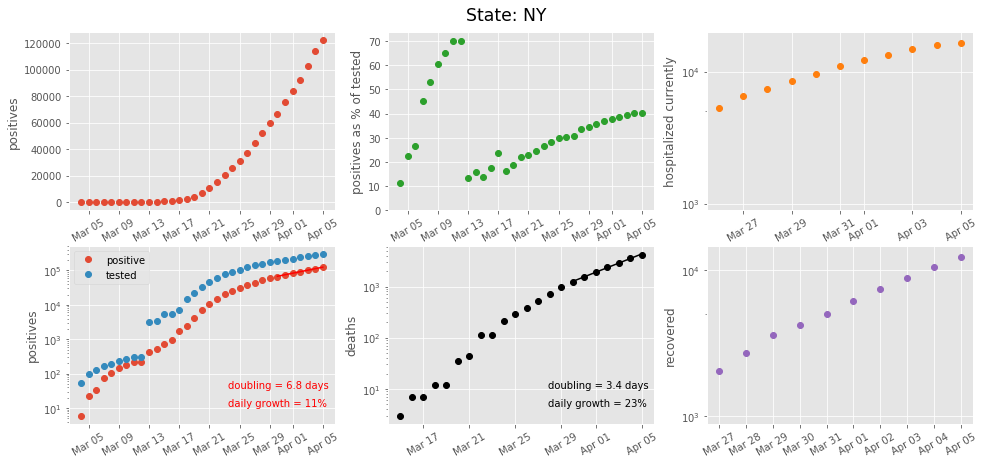

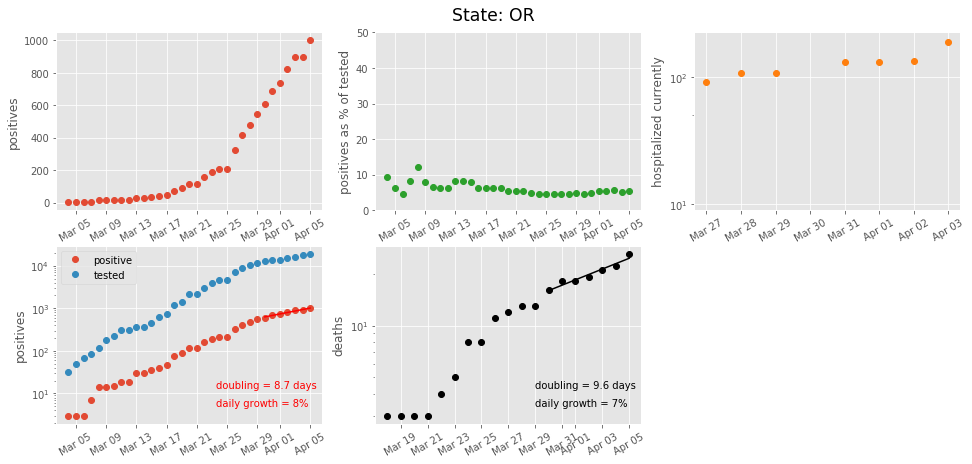

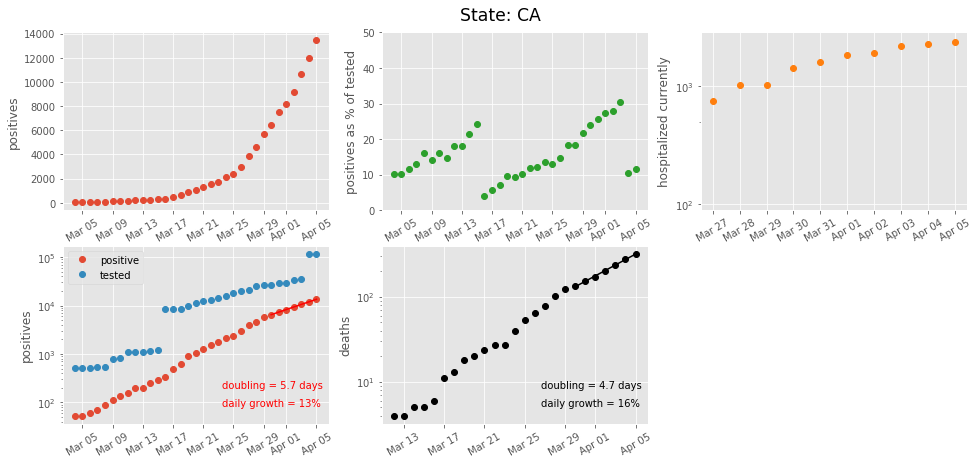

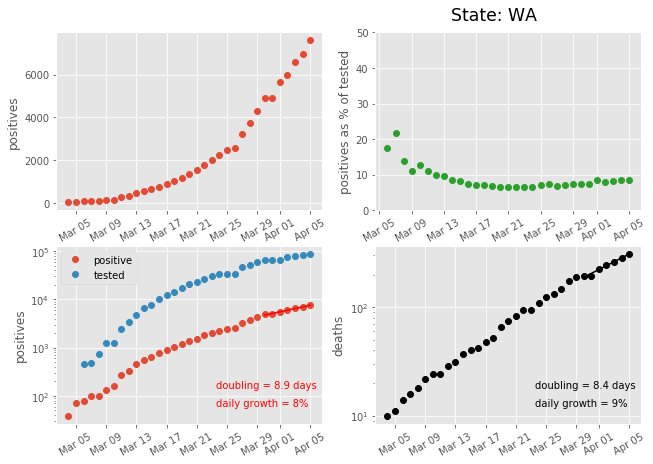

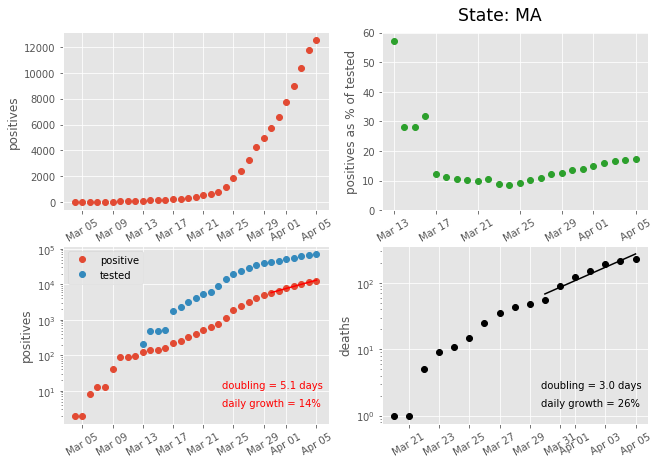

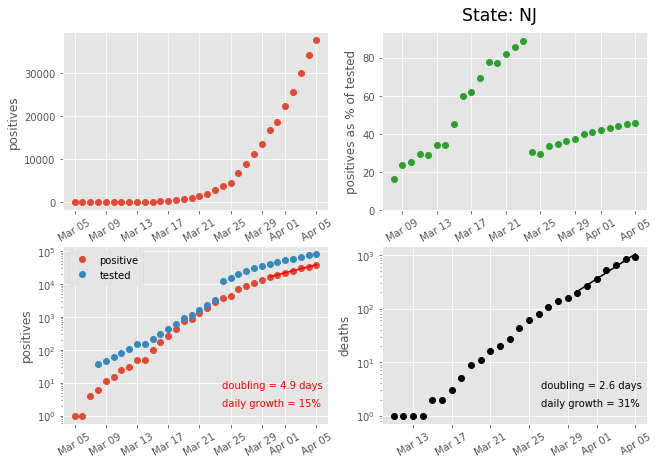

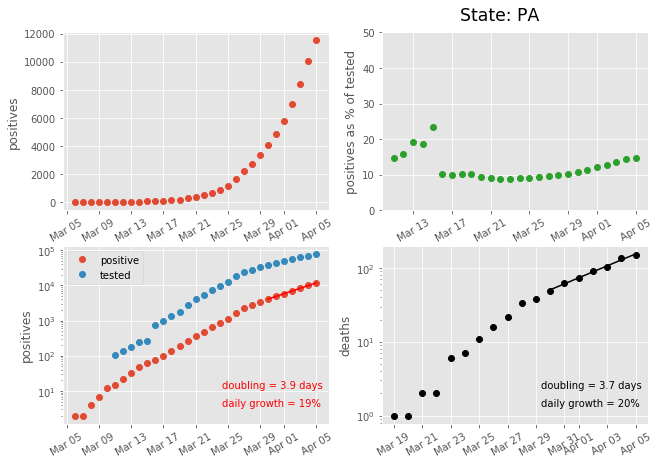

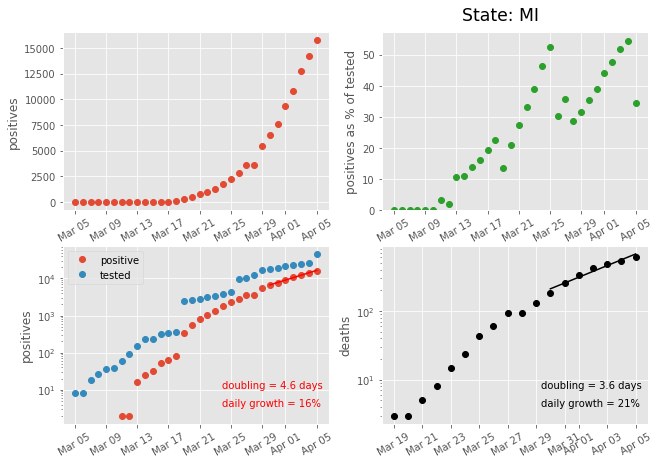

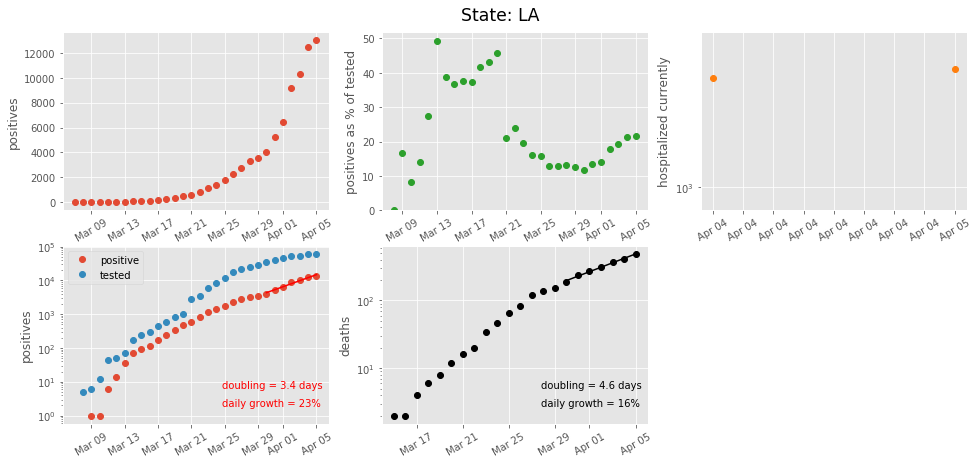

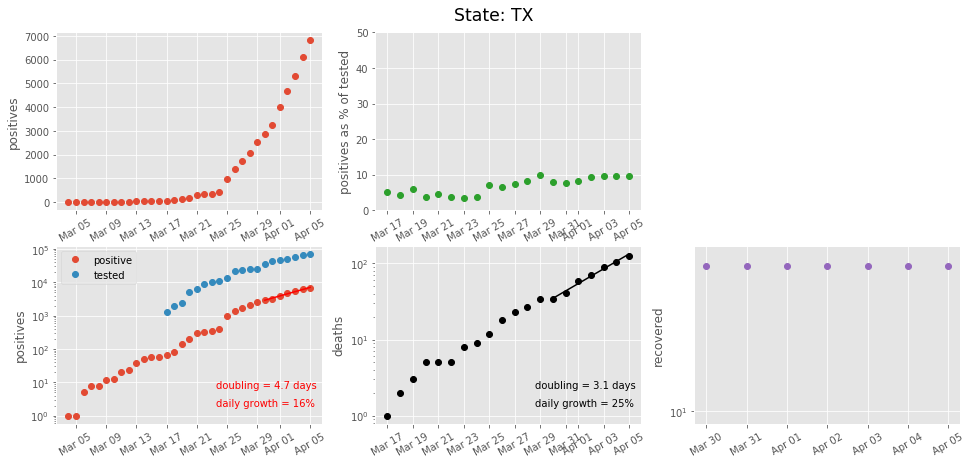

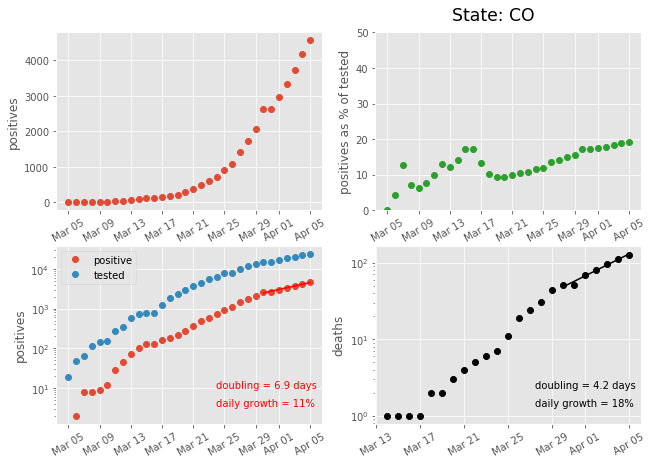

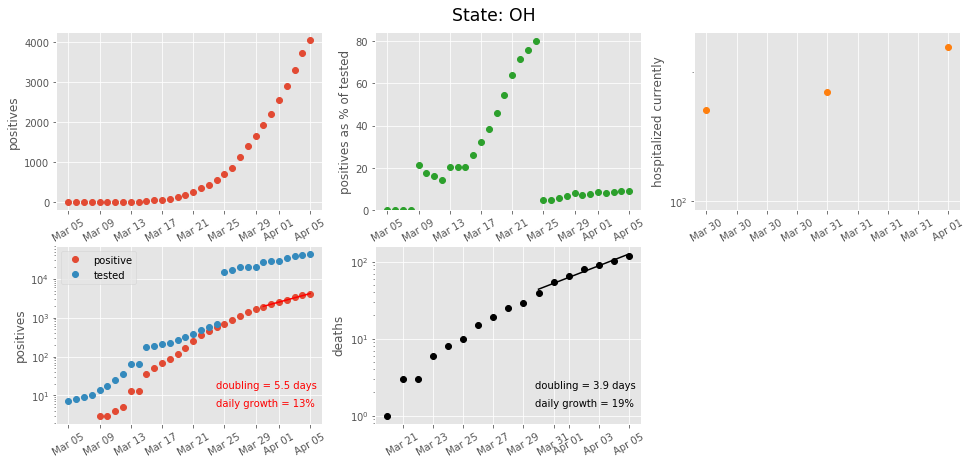

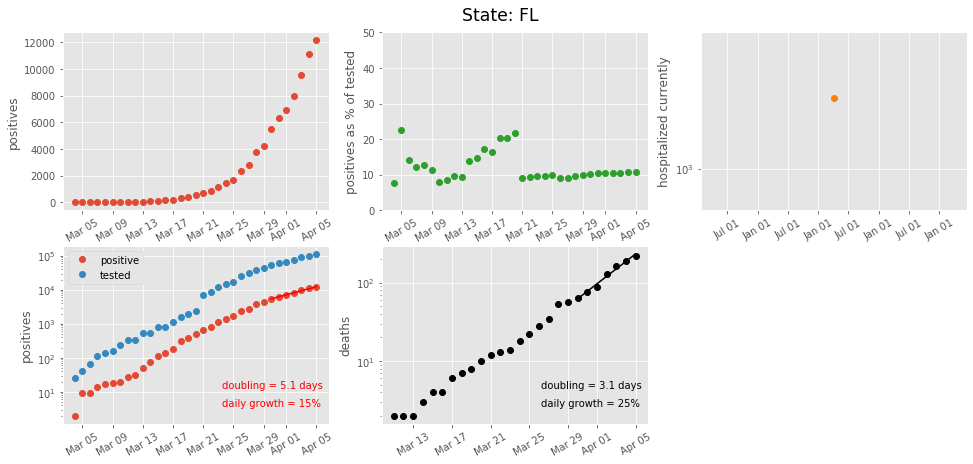

In [29]:
states = ['NY', 'OR', 'CA', 'WA', 'MA', 'NJ', 'PA', 'MI', 'LA', 'TX', 'CO', 'OH','FL']

lag_death = 7
lag_pos = 7
rowcols = (2,3)
for state in states:
    stdata = covid_data[covid_data.state==state]
    plot_state_data(state, stdata, rowcols=rowcols, PLOT_TOTAL=False, fit_lag_death=lag_death, fit_lag_pos=lag_pos)


# Entire US plots

In [30]:
covid_us_url = 'https://covidtracking.com/api/us/daily.csv'

In [31]:
covid_us_data = pd.read_csv(covid_us_url)

print(*list(covid_us_data.columns), sep=", ")
#covid_us_data

date, states, positive, negative, pending, hospitalizedCurrently, hospitalizedCumulative, inIcuCurrently, inIcuCumulative, onVentilatorCurrently, onVentilatorCumulative, recovered, hash, dateChecked, death, hospitalized, total, totalTestResults, posNeg, deathIncrease, hospitalizedIncrease, negativeIncrease, positiveIncrease, totalTestResultsIncrease


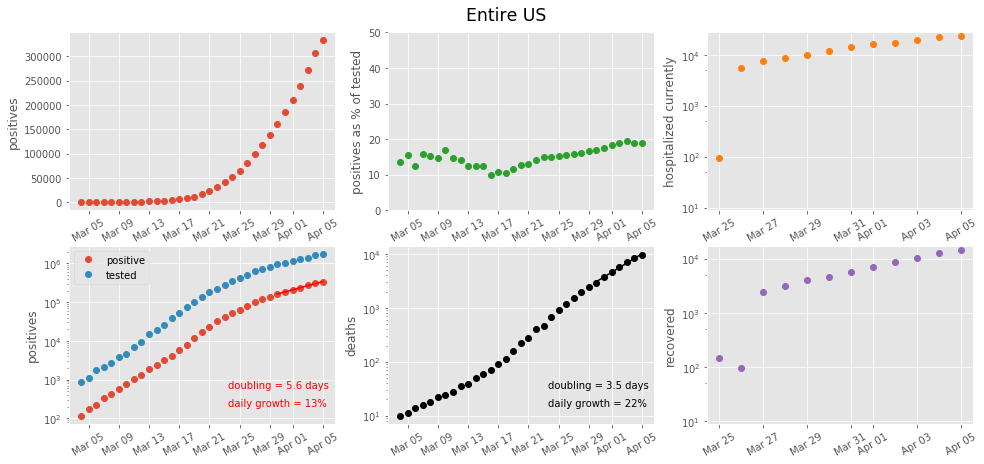

In [32]:
plot_state_data("entire US", covid_us_data, rowcols=rowcols, PLOT_TOTAL=False, fit_lag_death=lag_death, fit_lag_pos=lag_pos)